# The Thermal Expansion of MgO - Molecular Dynamics

Finally, we are going to calculate the volume of the MgO crystal, at different temperatures, by using Molecular Dynamics (MD). <br>

Molecular Dynamics is a technique for allowing a system to evolve in time according to Newton's second law. The atoms simply follow the trajectories that they would in reality and we can then compute properties as time averages of their behaviour.<br>

First of all an initial configuration and initial velocities need to be assigned - here the initial configuration will be that of ideal MgO and the velocities will be random but scaled to produce roughly the target temperature.<br>

MD computes the final volume at the requested temperature by using the Verlet algorithm:

* Compute the forces on the atoms (F).
    
* Compute the accelerations a=F/m
    
* Update the velocities: Vnew = Vold + a * dt
    
* Update the positions of the atoms: Rnew = Rold + Vnew * dt
    
* Repeat until average properties like E and T settle down
    
* Once settled measure some properties.

First, run the calculation for T=100K, a window will open to show you the cell used for this calculation. Then animate the motion of the atoms by using the cell below.<br>

Increase the T from 100K in 100K intervals. As in the previous exercise you can do so by manually changing the T value in the input below, or you can write a for loop that will do that for you.


**Please note that the simulation will takes few minutes**

In [48]:
#INPUT TO BE PROVIDED
#SELECT THE TEMPERATURE
T = 100

# generate the crystal starting from a geometry that is close to the optimised one
a = 4.212

In [1]:
#the imports first, always
import set_mygulp_vars
import numpy as np
import re
import os
from ase.build import make_supercell
from ase.io import Trajectory
from ase.build import cut
from os import remove
from ase.spacegroup import crystal
from ase.visualize import view
from ase.calculators.gulp import GULP


In [13]:

a = 4.212
#generate the conventional cell
MgO = crystal('MgO',basis=[[0.0,0.0,0.0],[0.5,0.5,0.5]],spacegroup=225,cellpar=[a, a, a, 90, 90, 90],primitive_cell=False)

#select the size of the supercell (NxNxN times the conventional cell)
supercell = 2
#create the supercell
MgO_SC_MD = make_supercell(MgO, supercell*np.identity(3))
#visualise the cell
view(MgO_SC_MD)
#name of the calculation
label='mgo_SC_MD_{}'.format(T)
#select the options for the calculations
options = [
'integrator leapfrog verlet',
'ensemble npt 0.005 0.005',
'temperature {}'.format(T),
'equil 0.50 ps',
'produ 0.50 ps',
'timestep 0.001 ps',
'sample 0.005 ps',
'iterations 5 ',
'dump every 5 noover {}.grs'.format(label)]
#run the calculation
calc = GULP(label=label,keywords='conp md', library='ionic.lib', options=options)
MgO_SC_MD.calc = calc
MgO_SC_MD.get_potential_energy()
#look for the optimised volume in the output
for line in reversed(list(open(label+'.got'))):
    a = re.match(r'\s*Cell volume\s*\S+\s*\S+\s*=\s*(\S+)\s*(\S+)', line)
    if a:
        V_final = a.group(2)
        print(T, ' (K) - Optimised Volume = ', a.group(2))
        break
#write the trajectory file to show the movement of the atoms at the temperature of the simulation
traj = Trajectory('{}K.trj'.format(label), 'w')    
for t in range(1,52):
    with open('{}_{}.grs'.format(label,t)) as o:
        pos_out = o.readlines()
        new_cell = np.zeros((3, 3), dtype=float)
        new_pos = np.zeros((MgO_SC_MD.get_number_of_atoms(), 3), dtype=float)
        for i,line in enumerate(pos_out):
            m =  re.match(r'vectors', line)
            if m:
                for j in range(0,3):
                    new_cell[j] = [float(x) for x in pos_out[i+j+1].split()]
            n = re.match(r'cartesian',line)
            if n:
                for j in range(0,MgO_SC_MD.get_number_of_atoms()):
                    first = pos_out[i+j+1].split()
                    first = first[2:5]
                    new_pos[j] = [float(x) for x in pos_out[i+j+1].split()[2:5]]    
        MgO_SC_MD.set_cell(new_cell)
        MgO_SC_MD.set_positions(new_pos)
        MgO_SC_MD_out = MgO_SC_MD
        MgO_SC_MD_out = cut(MgO_SC_MD, origo=(MgO_SC_MD.get_center_of_mass(scaled=True)),extend=1.01)
        traj.write(MgO_SC_MD_out)
traj.close()
#removing the files we don't need anymore to leave the directory clean
for i in range(1,52):
    if os.path.exists('./mgo_SC_MD_{}_{}.grs'.format(T,i)):
        os.remove('./mgo_SC_MD_{}_{}.grs'.format(T,i))
    else:
        break


100  (K) - Optimised Volume =  599.182534


In [25]:
#use this cell to animate the motion of the atoms. 
#You will have to change the name of the .trj file
#by updating the value of the temperature
! ase gui mgo_SC_MD_100K.trj 2> tmp

# My code

In [2]:
def get_V_MD(supercell_v,T):
    a = 4.212
    #generate the conventional cell
    MgO = crystal('MgO',basis=[[0.0,0.0,0.0],[0.5,0.5,0.5]],spacegroup=225,
                  cellpar=[a, a, a, 90, 90, 90],primitive_cell=False)

    #select the size of the supercell (NxNxN times the conventional cell)
    supercell = supercell_v
    #create the supercell
    MgO_SC_MD = make_supercell(MgO, supercell*np.identity(3))
    #visualise the cell
    #view(MgO_SC_MD)
    #name of the calculation
    label='mgo_SC_MD_{}'.format(T)
    #select the options for the calculations
    options = [
    'integrator leapfrog verlet',
    'ensemble npt 0.005 0.005',
    'temperature {}'.format(T),
    'equil 0.50 ps',
    'produ 0.50 ps',
    'timestep 0.001 ps',
    'sample 0.005 ps',
    'iterations 5 ',
    'dump every 5 noover {}.grs'.format(label)]
    #run the calculation
    calc = GULP(label=label,keywords='conp md', library='ionic.lib', options=options)
    MgO_SC_MD.calc = calc
    MgO_SC_MD.get_potential_energy()
    #look for the optimised volume in the output
    for line in reversed(list(open(label+'.got'))):
        a = re.match(r'\s*Cell volume\s*\S+\s*\S+\s*=\s*(\S+)\s*(\S+)', line)
        if a:
            V_final = a.group(2)
            print(T, ' (K) - Optimised Volume = ', a.group(2))
            break
    V_value = float(V_final)
    return V_value

In [5]:
supercell = [2,4,6,8]
V_matrix = []

T_list = np.arange(100,4001,50)
for j in supercell:
    V_a_list = []
    for i in T_list:
        V_a_list.append(get_V_MD(j,i))
    V_matrix.append(V_a_list)
    
V_matrix

100  (K) - Optimised Volume =  599.182534
150  (K) - Optimised Volume =  599.903343
200  (K) - Optimised Volume =  600.709155
250  (K) - Optimised Volume =  601.403263
300  (K) - Optimised Volume =  602.552907
350  (K) - Optimised Volume =  603.047641
400  (K) - Optimised Volume =  603.878445
450  (K) - Optimised Volume =  604.722069
500  (K) - Optimised Volume =  605.376913
550  (K) - Optimised Volume =  606.198415
600  (K) - Optimised Volume =  607.128531
650  (K) - Optimised Volume =  607.943531
700  (K) - Optimised Volume =  608.634066
750  (K) - Optimised Volume =  609.343847
800  (K) - Optimised Volume =  610.170850
850  (K) - Optimised Volume =  611.096800
900  (K) - Optimised Volume =  612.035290
950  (K) - Optimised Volume =  612.898235
1000  (K) - Optimised Volume =  613.640469
1050  (K) - Optimised Volume =  614.283317
1100  (K) - Optimised Volume =  614.911350
1150  (K) - Optimised Volume =  615.641816
1200  (K) - Optimised Volume =  616.573526
1250  (K) - Optimised Volume 

KeyboardInterrupt: 

In [ ]:
100  (K) - Optimised Volume =  599.182534
150  (K) - Optimised Volume =  599.903343
200  (K) - Optimised Volume =  600.709155
250  (K) - Optimised Volume =  601.403263
300  (K) - Optimised Volume =  602.552907
350  (K) - Optimised Volume =  603.047641
400  (K) - Optimised Volume =  603.878445
450  (K) - Optimised Volume =  604.722069
500  (K) - Optimised Volume =  605.376913
550  (K) - Optimised Volume =  606.198415
600  (K) - Optimised Volume =  607.128531
650  (K) - Optimised Volume =  607.943531
700  (K) - Optimised Volume =  608.634066
750  (K) - Optimised Volume =  609.343847
800  (K) - Optimised Volume =  610.170850
850  (K) - Optimised Volume =  611.096800
900  (K) - Optimised Volume =  612.035290
950  (K) - Optimised Volume =  612.898235
1000  (K) - Optimised Volume =  613.640469
1050  (K) - Optimised Volume =  614.283317
1100  (K) - Optimised Volume =  614.911350
1150  (K) - Optimised Volume =  615.641816
1200  (K) - Optimised Volume =  616.573526
1250  (K) - Optimised Volume =  617.727071
1300  (K) - Optimised Volume =  619.013450
1350  (K) - Optimised Volume =  620.278054
1400  (K) - Optimised Volume =  621.383458
1450  (K) - Optimised Volume =  622.313201
1500  (K) - Optimised Volume =  623.172849
1550  (K) - Optimised Volume =  624.054523
1600  (K) - Optimised Volume =  624.845473
1650  (K) - Optimised Volume =  625.754684
1700  (K) - Optimised Volume =  626.908295
1750  (K) - Optimised Volume =  628.007674
1800  (K) - Optimised Volume =  629.004360
1850  (K) - Optimised Volume =  629.757212
1900  (K) - Optimised Volume =  630.674905
1950  (K) - Optimised Volume =  632.225843
2000  (K) - Optimised Volume =  633.949961
2050  (K) - Optimised Volume =  635.189820
2100  (K) - Optimised Volume =  634.570630
2150  (K) - Optimised Volume =  635.627010
2200  (K) - Optimised Volume =  637.301420
2250  (K) - Optimised Volume =  637.644623
2300  (K) - Optimised Volume =  636.268986
2350  (K) - Optimised Volume =  638.601648
2400  (K) - Optimised Volume =  640.655769
2450  (K) - Optimised Volume =  642.029979
2500  (K) - Optimised Volume =  641.481674
2550  (K) - Optimised Volume =  644.074673
2600  (K) - Optimised Volume =  645.482999
2650  (K) - Optimised Volume =  650.916576
2700  (K) - Optimised Volume =  650.243246
2750  (K) - Optimised Volume =  653.519117
2800  (K) - Optimised Volume =  655.283797
2850  (K) - Optimised Volume =  657.105696
2900  (K) - Optimised Volume =  655.063466
2950  (K) - Optimised Volume =  655.313832
3000  (K) - Optimised Volume =  659.325471
3050  (K) - Optimised Volume =  658.820838
3100  (K) - Optimised Volume =  662.658983
3150  (K) - Optimised Volume =  662.690997
3200  (K) - Optimised Volume =  665.612812
3250  (K) - Optimised Volume =  661.422537
3300  (K) - Optimised Volume =  671.519185
3350  (K) - Optimised Volume =  668.398369
3400  (K) - Optimised Volume =  675.612181
3450  (K) - Optimised Volume =  672.320307
3500  (K) - Optimised Volume =  667.792463
3550  (K) - Optimised Volume =  670.236893
3600  (K) - Optimised Volume =  682.146094
3650  (K) - Optimised Volume =  679.566879
3700  (K) - Optimised Volume =  675.814644
3750  (K) - Optimised Volume =  683.847868
3800  (K) - Optimised Volume =  679.625940
3850  (K) - Optimised Volume =  686.680005
3900  (K) - Optimised Volume =  678.515750
3950  (K) - Optimised Volume =  679.514900
4000  (K) - Optimised Volume =  683.443036
100  (K) - Optimised Volume =  4794.472193
150  (K) - Optimised Volume =  4801.009697
200  (K) - Optimised Volume =  4807.393505
250  (K) - Optimised Volume =  4813.917000
300  (K) - Optimised Volume =  4820.086308
350  (K) - Optimised Volume =  4827.446869
400  (K) - Optimised Volume =  4834.808759
450  (K) - Optimised Volume =  4840.785619
500  (K) - Optimised Volume =  4846.732529
550  (K) - Optimised Volume =  4853.538171
600  (K) - Optimised Volume =  4860.891787
650  (K) - Optimised Volume =  4868.033659
700  (K) - Optimised Volume =  4874.568724
750  (K) - Optimised Volume =  4880.694941
800  (K) - Optimised Volume =  4886.875811
850  (K) - Optimised Volume =  4893.441675
900  (K) - Optimised Volume =  4900.434598
950  (K) - Optimised Volume =  4907.683782
1000  (K) - Optimised Volume =  4914.958275
1050  (K) - Optimised Volume =  4922.087497
1100  (K) - Optimised Volume =  4929.032866
1150  (K) - Optimised Volume =  4935.918595
1200  (K) - Optimised Volume =  4942.998905
1250  (K) - Optimised Volume =  4950.534971
1300  (K) - Optimised Volume =  4958.672069
1350  (K) - Optimised Volume =  4967.442096
1400  (K) - Optimised Volume =  4976.744141
1450  (K) - Optimised Volume =  4986.207079
1500  (K) - Optimised Volume =  4995.331900
1550  (K) - Optimised Volume =  5003.899505
1600  (K) - Optimised Volume =  5011.897474

In [6]:
V_matrix

[[599.182534,
  599.903343,
  600.709155,
  601.403263,
  602.552907,
  603.047641,
  603.878445,
  604.722069,
  605.376913,
  606.198415,
  607.128531,
  607.943531,
  608.634066,
  609.343847,
  610.17085,
  611.0968,
  612.03529,
  612.898235,
  613.640469,
  614.283317,
  614.91135,
  615.641816,
  616.573526,
  617.727071,
  619.01345,
  620.278054,
  621.383458,
  622.313201,
  623.172849,
  624.054523,
  624.845473,
  625.754684,
  626.908295,
  628.007674,
  629.00436,
  629.757212,
  630.674905,
  632.225843,
  633.949961,
  635.18982,
  634.57063,
  635.62701,
  637.30142,
  637.644623,
  636.268986,
  638.601648,
  640.655769,
  642.029979,
  641.481674,
  644.074673,
  645.482999,
  650.916576,
  650.243246,
  653.519117,
  655.283797,
  657.105696,
  655.063466,
  655.313832,
  659.325471,
  658.820838,
  662.658983,
  662.690997,
  665.612812,
  661.422537,
  671.519185,
  668.398369,
  675.612181,
  672.320307,
  667.792463,
  670.236893,
  682.146094,
  679.566879,
  6

# All data saved below

In [56]:
T_list_A = np.linspace(100,1001,100)
V_list_A = [599.182534,
 599.308094,
 599.463648,
 599.582759,
 599.715147,
 599.83284,
 599.990635,
 600.174109,
 600.307681,
 600.401513,
 600.527606,
 600.711618,
 600.91019,
 601.068074,
 601.169974,
 601.245387,
 601.340222,
 601.486269,
 601.687443,
 601.923711,
 602.164295,
 602.380991,
 602.556656,
 602.687887,
 602.782809,
 602.856387,
 602.925373,
 603.004241,
 603.102684,
 603.224811,
 603.36967,
 603.532595,
 603.70679,
 603.884961,
 604.060471,
 604.228266,
 604.385256,
 604.530309,
 604.664113,
 604.788722,
 604.907093,
 605.022597,
 605.138577,
 605.257992,
 605.383185,
 605.515746,
 605.656453,
 605.805318,
 605.961684,
 606.124379,
 606.291838,
 606.462274,
 606.633847,
 606.804769,
 606.973423,
 607.138483,
 607.298882,
 607.453946,
 607.603324,
 607.746989,
 607.885238,
 608.018612,
 608.147862,
 608.273912,
 608.397765,
 608.520467,
 608.643065,
 608.766565,
 608.891866,
 609.019766,
 609.15094,
 609.285878,
 609.424917,
 609.568317,
 609.716154,
 609.868339,
 610.024607,
 610.184673,
 610.348181,
 610.514655,
 610.683546,
 610.854298,
 611.026319,
 611.198995,
 611.371698,
 611.543898,
 611.714955,
 611.884334,
 612.05151,
 612.216023,
 612.377446,
 612.535419,
 612.689631,
 612.839859,
 612.985941,
 613.127789,
 613.265415,
 613.398906,
 613.528385,
 613.654109]
T_list_B = np.linspace(1000,4001,50)
V_list_B = [613.640469,
 614.421907,
 615.220224,
 616.244907,
 617.603006,
 619.175444,
 620.686511,
 621.934072,
 622.998341,
 624.074933,
 625.045744,
 626.28653,
 627.693711,
 628.934322,
 629.870328,
 631.155005,
 633.265549,
 635.044818,
 634.521251,
 636.279156,
 637.75507,
 636.440832,
 638.514491,
 640.512038,
 641.733394,
 643.705035,
 645.504739,
 651.007749,
 650.213048,
 657.686868,
 658.028863,
 655.226079,
 655.964292,
 657.561347,
 661.933242,
 664.099051,
 664.442618,
 663.360351,
 670.966562,
 670.322569,
 672.381735,
 671.152901,
 673.17788,
 676.028598,
 675.225953,
 682.928935,
 680.247563,
 689.178833,
 688.456367,
 682.447222]

In [63]:

plt.title("The Volume of the supercell against Temperature in MD\n")

plt.plot(T_list_A, V_list_A)
plt.plot(T_list_B, V_list_B)

plt.ylabel('Volume of the supercell (Å^3)')
plt.xlabel('T (K)')
plt.show()

In [70]:
LD_V[2]

18.838193

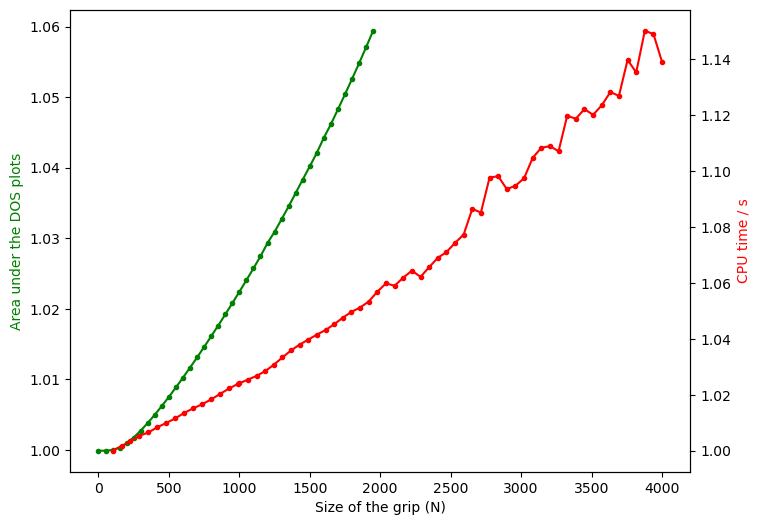

In [72]:
MD_V = np.array(V_list_A[::7]+V_list_B)/599.182534
MD_T = np.concatenate((T_list_A[::7],T_list_B))
LD_T = np.arange(0,2000,50)
LD_V = [18.836391, 18.836478, 18.838193, 18.844626, 18.856171, 18.871668, 18.890028, 18.910487, 18.932536, 18.955836, 18.980158, 19.005341, 19.0315, 19.058124, 19.085367, 19.113276, 19.14165, 19.170558, 19.199989, 19.229936, 19.2604, 19.291382, 19.322888, 19.355088, 19.390716, 19.420474, 19.454229, 19.488436, 19.524128, 19.5601, 19.595234, 19.63136, 19.671879, 19.707773, 19.747558, 19.787604, 19.828541, 19.870424, 19.913311, 19.957269]
LD_V=np.array(LD_V)/18.838193


plt.rcParams['figure.figsize'] = [8, 6]

fig, ax1 = plt.subplots()



ax2 = ax1.twinx()
ax1.plot(LD_T, LD_V,color='g',marker='.',linestyle='-')
ax2.plot(MD_T, MD_V,color='r',marker='.',linestyle='-')

ax1.set_xlabel('Size of the grip (N)')
ax1.set_ylabel('Area under the DOS plots', color='g')
ax2.set_ylabel('CPU time / s', color='r')


plt.show()

In [43]:
def grad(func,x0,step):
    y0 = func(x0)
    y1 = func(x0+step)
    grad_value = (y1-y0)/(step)
    return y1,grad_value

alpha_list = []
for i in T_list:
    y1,grad_value = grad(get_V_MD, i, 1)
    alpha = grad_value/y1
    alpha_list.append(alpha)
    
plt.title("Thermal Expansion Coefficient against Temperature in MD\n")

plt.plot(T_list, alpha_list)

plt.ylabel('Thermal Expansion Coefficient (K-1)')
plt.xlabel('T (K)')
plt.show()

100.0  (K) - Optimised Volume =  599.182534
T = 100.0 , Volume = 599.182534


KeyboardInterrupt: 

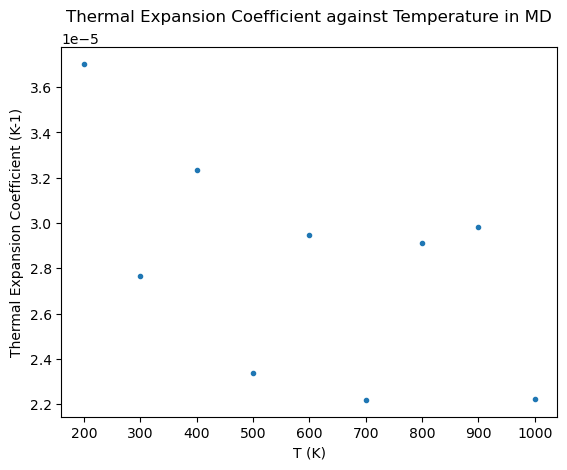

In [36]:
import matplotlib.pyplot as plt 

plt.title("Thermal Expansion Coefficient against Temperature in MD\n")

plt.plot(T_list[1:], alpha_list[1:], marker='.',linestyle='')

plt.ylabel('Thermal Expansion Coefficient (K-1)')
plt.xlabel('T (K)')
plt.show()

In [37]:
T_list

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])

**Questions**:<br>
1. Why do Molecular Dynamics simulations require a supercell, while Lattice Dynamics simulations can be performed with the primitive cell?<br>
<br>
2. Is the supercell we are using in Molecular Dynamics large enough? Explain why and design (additional calculations are not required) an exercise that validates the size of the cell. <br>
    <br>
3. Replot your data from the quasi-harmonic approximation calculations as cell volume per formula unit vs temperature; add some points from the MD runs at a few suitable temperatures. Calculate the thermal expansion coefficient for MD data.<br>
    - How does the thermal expansion predicted by MD compare to that predicted by the quasi-harmonic approximation  and with experimental values?<br>
    - Why do the two methods produce different answers? How does the difference depend on temperature?<br>
    
    - What would happen to the cell volume at very high temperature in MD?<br>

<a href="../main.ipynb">Main</a>  